<a href="https://colab.research.google.com/github/limited-fion/deep-learning-cw/blob/master/04_cw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Set up modules and functions needed**

## **Libraries and functions**

In [1]:
import scipy.ndimage as nd
import tensorflow as tf
import numpy as np
import time
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import keras
import scipy.ndimage

from matplotlib import font_manager as fm
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras.layers import Dense, Dropout, Activation, Flatten, Input, Convolution2D, MaxPooling2D, BatchNormalization, ReLU, LeakyReLU, Lambda, Conv2D
from keras import models
from keras.models import Sequential, load_model, Model
from keras import regularizers
from keras import initializers
from keras import metrics
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical, np_utils
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.datasets import cifar10
from tensorflow.keras.layers.experimental import preprocessing

from google.colab import drive
drive.mount('/content/drive')

!wget https://github.com/trishume/OpenTuringCompiler/blob/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf

font_files = fm.findSystemFonts()

# Go through and add each to Matplotlib's font cache.
for font_file in font_files:
    fm.fontManager.addfont(font_file)

# Use your new font on all your plots.
plt.rc('font', family='serif')

def plot_history(history, fileName, metric = None):
  # Plots the loss history of training and validation (if existing)
  # and a given metric
  # Be careful because the axis ranges are automatically adapted
  # which may not desirable to compare different runs.
  # Also, in some cases you may want to combine several curves in one
  # figure for easier comparison, which this function does not do.

  if metric != None:
    fig, axes = plt.subplots(2,1, figsize=(15,10))
    axes[0].plot(history.history[metric])
    try:
      axes[0].plot(history.history['val_'+metric])
      axes[0].legend(['Training', 'Validation'], fontsize=14)
      axes[0].tick_params(axis='x', which='major', labelsize=12)
      axes[0].tick_params(axis='y', which='major', labelsize=12)
    except:
      pass
    axes[0].set_title('Validation Accuracy', fontsize = 18)
    axes[0].set_ylabel('Accuracy', fontsize = 14)
    axes[0].set_xlabel('Epoch', fontsize = 14)
    fig.subplots_adjust(hspace=0.35)
    axes[1].plot(history.history['loss'])
    try:
      axes[1].plot(history.history['val_loss'])
      axes[1].legend(['Training', 'Validation'], fontsize=14)
      axes[1].tick_params(axis='x', which='major', labelsize=12)
      axes[1].tick_params(axis='y', which='major', labelsize=12)
    except:
      pass
    axes[1].set_title('Model Loss', fontsize = 18)
    axes[1].set_ylabel('Loss', fontsize = 14)
    axes[1].set_xlabel('Epoch', fontsize = 14)
  else:
    plt.plot(history.history['loss'])
    try:
      plt.plot(history.history['val_loss'])
      plt.legend(['Training', 'Validation'], fontsize=14)
    except:
      pass
    plt.title('Model Loss', fontsize = 18)
    plt.yticks(fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.ylabel('Loss', fontsize = 14)
    plt.xlabel('Epoch', fontsize = 14)

  directory = '/content/drive/MyDrive/dl-cw-04/diagrams/'
  
  if not os.path.exists(directory):
    os.makedirs(directory)

  plt.savefig(os.path.join(directory, fileName))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2023-03-05 01:54:33--  https://github.com/trishume/OpenTuringCompiler/blob/master/stdlib-sfml/fonts/Times%20New%20Roman.ttf
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘Times New Roman.ttf.9’

Times New Roman.ttf     [ <=>                ] 137.23K  --.-KB/s    in 0.04s   

2023-03-05 01:54:34 (3.50 MB/s) - ‘Times New Roman.ttf.9’ saved [140528]



In [2]:
# Load CIFAR-10
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Image shape: {0}'.format(X_train.shape[1:]))
print('Total number of training samples: {0}'.format(X_train.shape[0]))
print('Total number of validation samples: {0}'.format(X_test.shape[0]))

X_train = X_train.reshape(-1,32,32,3)

## Normalization block
norm_layer = preprocessing.Normalization()
norm_layer.adapt(X_train)
X_train_n = norm_layer(X_train)
X_test_n = norm_layer(X_test)

Image shape: (32, 32, 3)
Total number of training samples: 50000
Total number of validation samples: 10000


## **TinyImageNet**

fatal: destination path 'IMagenet' already exists and is not an empty directory.
starting loading data
finished loading data, in 25.116676330566406 seconds


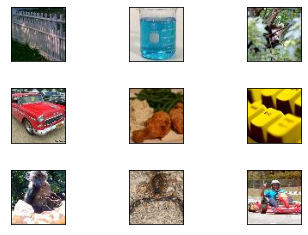

In [3]:
# download TinyImageNet
! git clone https://github.com/seshuad/IMagenet

def get_id_dictionary():
    id_dict = {}
    for i, line in enumerate(open('IMagenet/tiny-imagenet-200/wnids.txt', 'r')):
        id_dict[line.replace('\n', '')] = i
    return id_dict
  
def get_class_to_id_dict():
    id_dict = get_id_dictionary()
    all_classes = {}
    result = {}
    for i, line in enumerate(open('IMagenet/tiny-imagenet-200/words.txt', 'r')):
        n_id, word = line.split('\t')[:2]
        all_classes[n_id] = word
    for key, value in id_dict.items():
        result[value] = (key, all_classes[key])
        
    return result

def get_data(id_dict):

    print('starting loading data')
    train_data, val_data, test_data = [], [], []
    train_labels, val_labels, test_labels = [], [], []
    t = time.time()
    for key, value in id_dict.items():
        train_data += [cv2.imread('IMagenet/tiny-imagenet-200/train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(450)]
        
        train_labels_ = np.array([[0]*200]*450)
        train_labels_[:, value] = 1
        train_labels += train_labels_.tolist()
        
        val_data += [cv2.imread('IMagenet/tiny-imagenet-200/train/{}/images/{}_{}.JPEG'.format(key, key, str(i))) for i in range(450, 500)]
        
        val_labels_ = np.array([[0]*200]*50)
        val_labels_[:, value] = 1
        val_labels += val_labels_.tolist()

    for line in open('IMagenet/tiny-imagenet-200/val/val_annotations.txt'):
        img_name, class_id = line.split('\t')[:2]
        test_data.append(cv2.imread('IMagenet/tiny-imagenet-200/val/images/{}'.format(img_name)))

        test_labels_ = np.array([[0]*200])
        test_labels_[0, id_dict[class_id]] = 1
        test_labels += test_labels_.tolist()

    print('finished loading data, in {} seconds'.format(time.time() - t))

    return np.array(train_data), np.array(train_labels), np.array(val_data), np.array(val_labels), np.array(test_data), np.array(test_labels)
  
def shuffle_data(train_data, train_labels, val_data, val_labels):
    # This function shuffles separately the train set and the 
    # validation set
    size = len(train_data)
    train_idx = np.arange(size)
    np.random.shuffle(train_idx)
    
    size = len(val_data)
    val_idx = np.arange(size)
    np.random.shuffle(val_idx)

    return train_data[train_idx], train_labels[train_idx], val_data[val_idx], val_labels[val_idx]

train_data, train_labels, val_data, val_labels, test_data, test_labels = get_data(get_id_dictionary())
train_data, train_labels, val_data, val_labels = shuffle_data(train_data, train_labels, val_data, val_labels)

# Let's visualize some examples
N=3
start_val = 0 # pick an element for the code to plot the following N**2 values
fig, axes = plt.subplots(N,N)
for row in range(N):
  for col in range(N):
    idx = start_val+row+N*col    
    tmp = cv2.cvtColor(train_data[idx],cv2.COLOR_BGR2RGB)
    axes[row,col].imshow(tmp, cmap='gray')
    fig.subplots_adjust(hspace=0.5)
    axes[row,col].set_xticks([])
    axes[row,col].set_yticks([])

train_data = train_data.astype('float32') / 255.
val_data = val_data.astype('float32') / 255.
test_data = test_data.astype('float32') / 255.

mean = np.mean(train_data,axis=(0,1,2,3))
std = np.std(train_data, axis=(0, 1, 2, 3))
train_data = (train_data-mean)/(std+1e-7)
val_data = (val_data-mean)/(std+1e-7)
test_data = (test_data-mean)/(std+1e-7)

In [4]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

print('Original training data shape: {}'.format(train_data.shape))
print('Original validation data shape: {}'.format(val_data.shape))
print('Training label shape: {}'.format(train_labels.shape))

Original training data shape: (90000, 64, 64, 3)
Original validation data shape: (10000, 64, 64, 3)
Training label shape: (90000, 200)


## **Functions for cleaner code**

In [5]:
def get_and_process_cifar10_data():
  # Load CIFAR-10
  (X_train, y_train), (X_test, y_test) = cifar10.load_data()

  X_train = X_train.reshape(-1,32,32,3)

  ## Normalization block
  norm_layer = preprocessing.Normalization()
  norm_layer.adapt(X_train)
  X_train_n = norm_layer(X_train)
  X_test_n = norm_layer(X_test)

def get_and_process_imagenet_data():
  train_data, train_labels, val_data, val_labels, test_data, test_labels = get_data(get_id_dictionary())
  train_data, train_labels, val_data, val_labels = shuffle_data(train_data, train_labels, val_data, val_labels)

  train_data = train_data.astype('float32') / 255.
  val_data = val_data.astype('float32') / 255.
  test_data = test_data.astype('float32') / 255.

  mean = np.mean(train_data,axis=(0,1,2,3))
  std = np.std(train_data, axis=(0, 1, 2, 3))
  train_data = (train_data-mean)/(std+1e-7)
  val_data = (val_data-mean)/(std+1e-7)
  test_data = (test_data-mean)/(std+1e-7)

def load_vgg16_resize_input_to_32x32():
  # Load initial VGG16
  model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
  # model.summary()

  # Modify dense layers according to the resolution of input image
  # Preprocessing to resize image
  # ie 32x32
  newInput = Input(batch_shape=(None, 32, 32, 3))
  resizedImg = Lambda(lambda image: tf.compat.v1.image.resize_images(image, (224, 224)))(newInput)
  newOutputs = model(resizedImg)
  model = Model(newInput, newOutputs)

def load_vgg16_resize_input_to_64x64():
  # Load initial VGG16
  model = VGG16(weights='imagenet', include_top=True, input_shape=(224, 224, 3))
  # model.summary()

  # Modify dense layers according to the resolution of input image
  # Preprocessing to resize image
  # ie 32x32
  newInput = Input(batch_shape=(None, 64, 64, 3))
  resizedImg = Lambda(lambda image: tf.compat.v1.image.resize_images(image, (224, 224)))(newInput)
  newOutputs = model(resizedImg)
  model = Model(newInput, newOutputs)

# **VGG16 Transfer Learning**

### 1

In [9]:
get_and_process_imagenet_data()

load_vgg16_resize_input_to_64x64()

# Load VGG16
modelname = 'tl_model'
modelname = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers
for layer in modelname.layers[:]:
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
    
# Included new fully-connected layers with only 200 activations for 200 classes
# Add the same dense layers as in VGG16
output = modelname.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=200, activation='softmax')(output)
modelname = Model(modelname.input, output)

modelname.summary()

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)

modelname.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history_tl = modelname.fit(train_data, train_labels, epochs=20, batch_size=128, validation_data=(val_data, val_labels), callbacks=[early_stopping])

start_time = time.time()
score = modelname.evaluate(test_data, test_labels)
print(" ")
time_elapsed = time.time() - start_time
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

starting loading data
finished loading data, in 11.828712224960327 seconds
Layer input_3 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_c

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
704/704 [==============================] - 51s 59ms/step - loss: 2.8169 - categorical_accuracy: 0.3535 - val_loss: 2.3385 - val_categorical_accuracy: 0.4271
Epoch 2/20
704/704 [==============================] - 44s 63ms/step - loss: 2.0124 - categorical_accuracy: 0.5008 - val_loss: 2.2037 - val_categorical_accuracy: 0.4559
Epoch 3/20
704/704 [==============================] - 42s 60ms/step - loss: 1.6656 - categorical_accuracy: 0.5768 - val_loss: 2.1865 - val_categorical_accuracy: 0.4663
Epoch 4/20
704/704 [==============================] - 43s 61ms/step - loss: 1.3650 - categorical_accuracy: 0.6482 - val_loss: 2.1824 - val_categorical_accuracy: 0.4771
Epoch 5/20
704/704 [==============================] - 43s 61ms/step - loss: 1.0806 - categorical_accuracy: 0.7220 - val_loss: 2.2160 - val_categorical_accuracy: 0.4784
Epoch 6/20
704/704 [==============================] - 43s 61ms/step - loss: 0.8137 - categorical_accuracy: 0.7946 - val_loss: 2.2930 - val_categorical_accuracy:

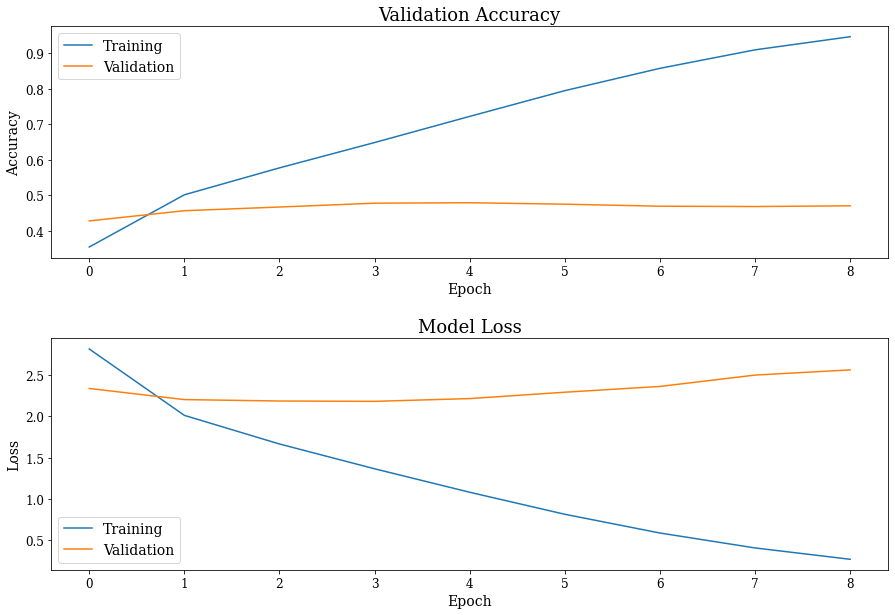

In [11]:
plot_history(history_tl, 'tl.png', metric='categorical_accuracy')

### 2

In [6]:
get_and_process_imagenet_data()

load_vgg16_resize_input_to_64x64()

# Load VGG16
modelname = 'tl2_model'
modelname = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers
for layer in modelname.layers[:]:
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
    
# Included new fully-connected layers with only 200 activations for 200 classes
# Add the same dense layers as in VGG16
output = modelname.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(units=4096, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(units=2048, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(units=1024, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(units=200, activation='softmax')(output)
modelname = Model(modelname.input, output)

modelname.summary()

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)

modelname.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history_tl2 = modelname.fit(train_data, train_labels, epochs=20, batch_size=128, validation_data=(val_data, val_labels), callbacks=[early_stopping])

start_time = time.time()
score = modelname.evaluate(test_data, test_labels)
print(" ")
time_elapsed = time.time() - start_time
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

starting loading data
finished loading data, in 14.217144012451172 seconds
Layer input_3 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_c

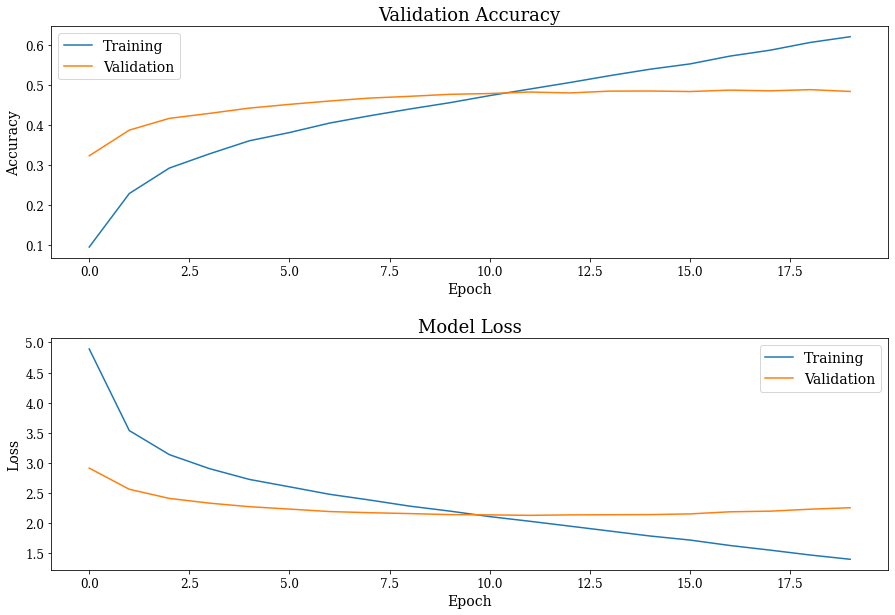

In [7]:
plot_history(history_tl2, 'tl2.png', metric='categorical_accuracy')

### 3

In [ ]:
get_and_process_cifar10_data()

load_vgg16_resize_input_to_32x32()

Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)  

# Load VGG16
modelname = 'cifar_tl3_model'
modelname = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers
for layer in modelname.layers[:]:
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
    
# Included new fully-connected layers with only 200 activations for 200 classes
# Add the same dense layers as in VGG16
output = modelname.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.3)(output)
output = Dense(units=4096, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.3)(output)
output = Dense(units=4096, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.3)(output)
output = Dense(units=4096, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.3)(output)
output = Dense(units=10, activation='softmax')(output)
modelname = Model(modelname.input, output)

modelname.summary()

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)

modelname.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history_cifar_tl3 = modelname.fit(X_train_n, Y_train_class, epochs=20, batch_size=32, validation_data=(X_test_n, Y_test_class), callbacks=[early_stopping])

start_time = time.time()
score = modelname.evaluate(X_test_n, Y_test_class)
print(" ")
time_elapsed = time.time() - start_time
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(X_test_n)))

Layer input_54 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.
Model: "model_34"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_54 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 36s 22ms/step - loss: 1.7916 - categorical_accuracy: 0.5032 - val_loss: 1.2803 - val_categorical_accuracy: 0.5867
Epoch 2/20
1563/1563 [==============================] - 34s 22ms/step - loss: 1.2877 - categorical_accuracy: 0.5854 - val_loss: 1.1846 - val_categorical_accuracy: 0.6067
Epoch 3/20
1563/1563 [==============================] - 34s 22ms/step - loss: 1.1370 - categorical_accuracy: 0.6236 - val_loss: 1.0808 - val_categorical_accuracy: 0.6299
Epoch 4/20
1563/1563 [==============================] - 34s 22ms/step - loss: 1.0505 - categorical_accuracy: 0.6435 - val_loss: 1.0276 - val_categorical_accuracy: 0.6609
Epoch 5/20
1563/1563 [==============================] - 34s 22ms/step - loss: 0.9597 - categorical_accuracy: 0.6715 - val_loss: 1.0349 - val_categorical_accuracy: 0.6601
Epoch 6/20
1563/1563 [==============================] - 34s 22ms/step - loss: 0.8819 - categorical_accuracy: 0.6965 - val_loss: 1.0199 - val_categorical_accuracy

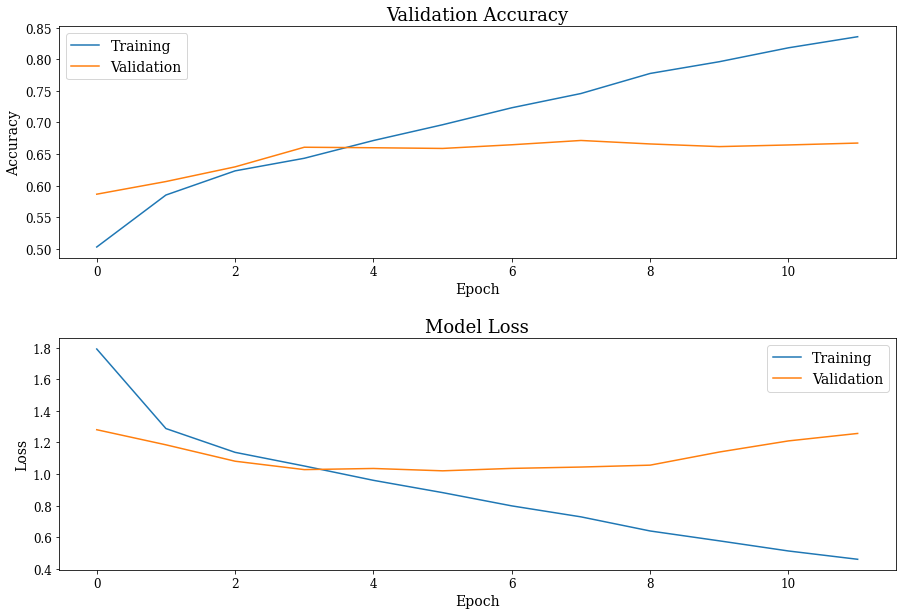

In [ ]:
plot_history(history_cifar_tl3, 'cifar-tl3.png', metric='categorical_accuracy')

### 4

In [ ]:
get_and_process_cifar10_data()

load_vgg16_resize_input_to_32x32()

Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)  

# Load VGG16
modelname = 'cifar_tl4_model'
modelname = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers
for layer in modelname.layers[:]:
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
    
# Included new fully-connected layers with only 200 activations for 200 classes
# Add the same dense layers as in VGG16
output = modelname.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(units=4096, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(units=4096, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(units=4096, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(units=10, activation='softmax')(output)
modelname = Model(modelname.input, output)

modelname.summary()

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)

modelname.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history_cifar_tl4 = modelname.fit(X_train_n, Y_train_class, epochs=20, batch_size=32, validation_data=(X_test_n, Y_test_class), callbacks=[early_stopping])

start_time = time.time()
score = modelname.evaluate(X_test_n, Y_test_class)
print(" ")
time_elapsed = time.time() - start_time
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(X_test_n)))

Layer input_57 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.
Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_57 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                

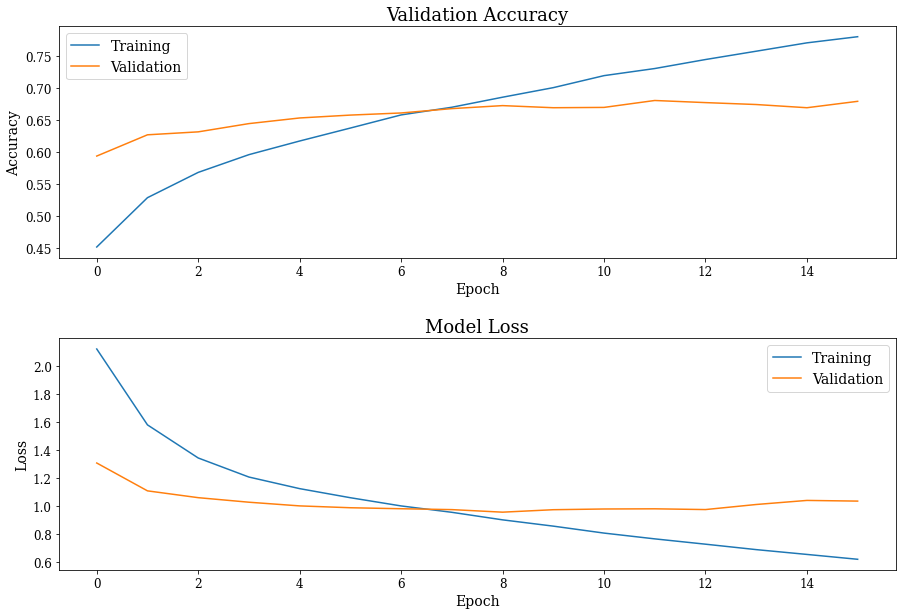

In [ ]:
plot_history(history_cifar_tl4, 'cifar-tl4.png', metric='categorical_accuracy')

### 5

In [ ]:
get_and_process_cifar10_data()

load_vgg16_resize_input_to_32x32()

Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)  

# Load VGG16
modelname = 'cifar_tl5_model'
modelname = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers
for layer in modelname.layers[:]:
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
    
# Included new fully-connected layers with only 200 activations for 200 classes
# Add the same dense layers as in VGG16
output = modelname.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(units=4096, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(units=2048, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(units=1024, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(units=10, activation='softmax')(output)
modelname = Model(modelname.input, output)

modelname.summary()

def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 6
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

lrate = keras.callbacks.LearningRateScheduler(lr_scheduler)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)

modelname.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history_cifar_tl5 = modelname.fit(X_train_n, Y_train_class, epochs=20, batch_size=32, validation_data=(X_test_n, Y_test_class), callbacks=[early_stopping,lrate])

start_time = time.time()
score = modelname.evaluate(X_test_n, Y_test_class)
print(" ")
time_elapsed = time.time() - start_time
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(X_test_n)))

Layer input_60 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.
Model: "model_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_60 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 31s 18ms/step - loss: 1.9420 - categorical_accuracy: 0.4434 - val_loss: 1.1562 - val_categorical_accuracy: 0.6033 - lr: 1.0000e-04
Epoch 2/20
1563/1563 [==============================] - 26s 17ms/step - loss: 1.5023 - categorical_accuracy: 0.5241 - val_loss: 1.0708 - val_categorical_accuracy: 0.6328 - lr: 1.0000e-04
Epoch 3/20
1563/1563 [==============================] - 26s 17ms/step - loss: 1.3125 - categorical_accuracy: 0.5653 - val_loss: 1.0286 - val_categorical_accuracy: 0.6398 - lr: 1.0000e-04
Epoch 4/20
1563/1563 [==============================] - 26s 17ms/step - loss: 1.1878 - categorical_accuracy: 0.5964 - val_loss: 0.9940 - val_categorical_accuracy: 0.6500 - lr: 1.0000e-04
Epoch 5/20
1563/1563 [==============================] - 26s 17ms/step - loss: 1.1157 - categorical_accuracy: 0.6170 - val_loss: 0.9756 - val_categorical_accuracy: 0.6617 - lr: 1.0000e-04
Epoch 6/20
1563/1563 [==============================] - 26s 17ms/step - loss

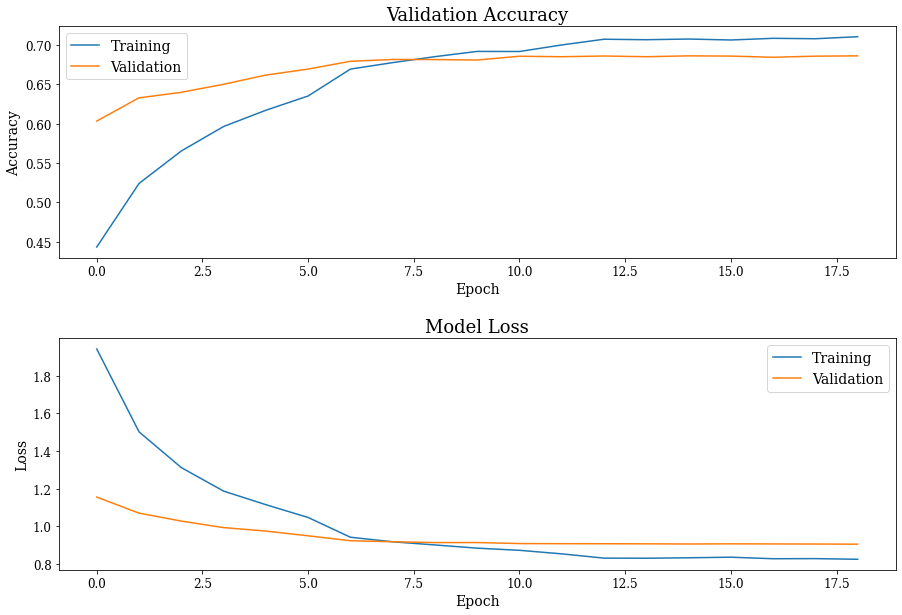

In [ ]:
plot_history(history_cifar_tl5, 'cifar-tl5.png', metric='categorical_accuracy')

### 6

In [6]:
get_and_process_cifar10_data()

load_vgg16_resize_input_to_32x32()

Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)  

# Load VGG16
modelname = 'cifar_tl6_model'
modelname = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers
for layer in modelname.layers[:]:
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
    
# Included new fully-connected layers with only 200 activations for 200 classes
# Add the same dense layers as in VGG16
output = modelname.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(units=2048, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.6)(output)
output = Dense(units=1024, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.6)(output)
output = Dense(units=10, activation='softmax')(output)
modelname = Model(modelname.input, output)

modelname.summary()

def lr_scheduler(epoch, lr):
    decay_rate = 0.1
    decay_step = 7
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

lrate = keras.callbacks.LearningRateScheduler(lr_scheduler)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)

modelname.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history_cifar_tl6 = modelname.fit(X_train_n, Y_train_class, epochs=20, batch_size=32, validation_data=(X_test_n, Y_test_class), callbacks=[early_stopping,lrate])

start_time = time.time()
score = modelname.evaluate(X_test_n, Y_test_class)
print(" ")
time_elapsed = time.time() - start_time
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(X_test_n)))

Layer input_9 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                  

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1563/1563 [==============================] - 24s 14ms/step - loss: 2.0735 - categorical_accuracy: 0.4323 - val_loss: 1.1360 - val_categorical_accuracy: 0.6188 - lr: 1.0000e-04
Epoch 2/20
1563/1563 [==============================] - 20s 13ms/step - loss: 1.5759 - categorical_accuracy: 0.5196 - val_loss: 1.0624 - val_categorical_accuracy: 0.6332 - lr: 1.0000e-04
Epoch 3/20
1563/1563 [==============================] - 20s 13ms/step - loss: 1.3716 - categorical_accuracy: 0.5551 - val_loss: 1.0128 - val_categorical_accuracy: 0.6477 - lr: 1.0000e-04
Epoch 4/20
1563/1563 [==============================] - 20s 13ms/step - loss: 1.2376 - categorical_accuracy: 0.5830 - val_loss: 0.9868 - val_categorical_accuracy: 0.6565 - lr: 1.0000e-04
Epoch 5/20
1563/1563 [==============================] - 20s 13ms/step - loss: 1.1517 - categorical_accuracy: 0.6085 - val_loss: 0.9705 - val_categorical_accuracy: 0.6615 - lr: 1.0000e-04
Epoch 6/20
1563/1563 [==============================] - 20s 13ms/step - loss

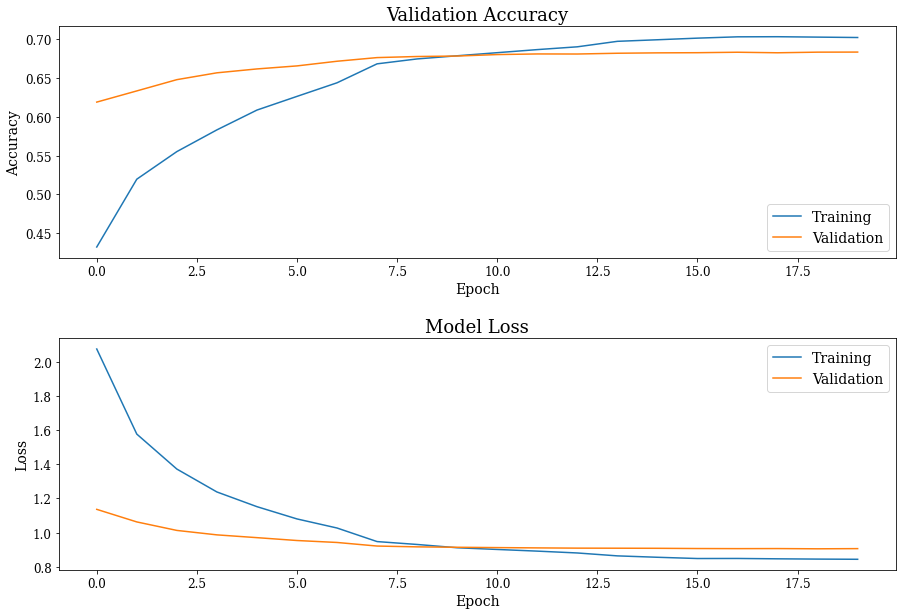

In [7]:
plot_history(history_cifar_tl6, 'cifar-tl6.png', metric='categorical_accuracy')

### 7


In [4]:
get_and_process_cifar10_data()

load_vgg16_resize_input_to_32x32()

Y_train_class = np_utils.to_categorical(y_train, 10)
Y_test_class = np_utils.to_categorical(y_test, 10)  

# Load VGG16
modelname = 'cifar_tl7_model'
modelname = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers
for layer in modelname.layers[:]:
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
    
# Included new fully-connected layers with only 200 activations for 200 classes
# Add the same dense layers as in VGG16
output = modelname.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(units=2048, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.6)(output)
output = Dense(units=1024, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.7)(output)
output = Dense(units=10, activation='softmax')(output)
modelname = Model(modelname.input, output)

modelname.summary()

def lr_scheduler(epoch, lr):
    decay_rate = 0.5
    decay_step = 6
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

lrate = keras.callbacks.LearningRateScheduler(lr_scheduler)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)

modelname.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history_cifar_tl7 = modelname.fit(X_train_n, Y_train_class, epochs=20, batch_size=32, validation_data=(X_test_n, Y_test_class), callbacks=[early_stopping,lrate])

start_time = time.time()
score = modelname.evaluate(X_test_n, Y_test_class)
print(" ")
time_elapsed = time.time() - start_time
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(X_test_n)))

58889256/58889256 [==============================] - 1s 0us/step
Layer input_3 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
1563/1563 [==============================] - 33s 15ms/step - loss: 2.3333 - categorical_accuracy: 0.4142 - val_loss: 1.2018 - val_categorical_accuracy: 0.6087 - lr: 1.0000e-04
Epoch 2/20
1563/1563 [==============================] - 21s 13ms/step - loss: 1.7355 - categorical_accuracy: 0.5025 - val_loss: 1.0967 - val_categorical_accuracy: 0.6341 - lr: 1.0000e-04
Epoch 3/20
1563/1563 [==============================] - 20s 13ms/step - loss: 1.4676 - categorical_accuracy: 0.5433 - val_loss: 1.0268 - val_categorical_accuracy: 0.6420 - lr: 1.0000e-04
Epoch 4/20
1563/1563 [==============================] - 21s 13ms/step - loss: 1.2967 - categorical_accuracy: 0.5699 - val_loss: 1.0038 - val_categorical_accuracy: 0.6475 - lr: 1.0000e-04
Epoch 5/20
1563/1563 [==============================] - 21s 13ms/step - loss: 1.1884 - categorical_accuracy: 0.5984 - val_loss: 0.9846 - val_categorical_accuracy: 0.6578 - lr: 1.0000e-04
Epoch 6/20
1563/1563 [==============================] - 21s 13ms/

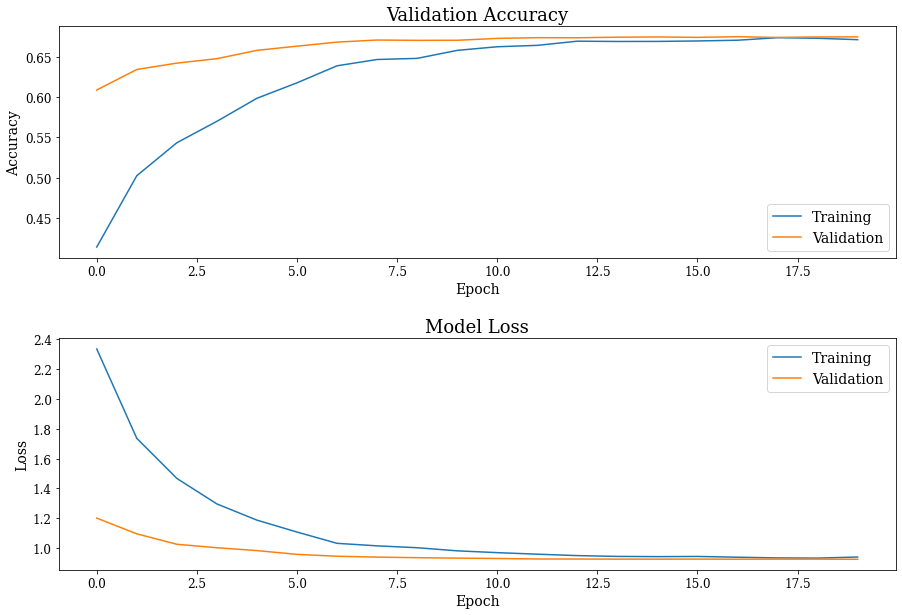

In [29]:
plot_history(history_cifar_tl7, 'cifar-tl7.png', metric='categorical_accuracy')

# **VGG16 Fine Tuning**

In [19]:
for layers in modelname.layers[0:15]:
  print(layers.name)

input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool


In [6]:
get_and_process_imagenet_data()

load_vgg16_resize_input_to_64x64()

# Load VGG16
modelname = 'ft_model'
modelname = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers
for layer in modelname.layers[0:15]:
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
    
# Included new fully-connected layers with only 200 activations for 200 classes
# Add the same dense layers as in VGG16
output = modelname.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(units=2048, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.6)(output)
output = Dense(units=1024, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.6)(output)
output = Dense(units=200, activation='softmax')(output)
modelname = Model(modelname.input, output)

modelname.summary()

def lr_scheduler(epoch, lr):
    decay_rate = 0.5
    decay_step = 7
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

lrate = keras.callbacks.LearningRateScheduler(lr_scheduler)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)

modelname.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history_ft = modelname.fit(train_data, train_labels, epochs=20, batch_size=128, validation_data=(val_data, val_labels), callbacks=[early_stopping, lrate])

start_time = time.time()
score = modelname.evaluate(test_data, test_labels)
print(" ")
time_elapsed = time.time() - start_time
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

starting loading data
finished loading data, in 11.058467388153076 seconds
Layer input_3 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                  

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
704/704 [==============================] - 60s 68ms/step - loss: 5.1116 - categorical_accuracy: 0.0786 - val_loss: 3.0448 - val_categorical_accuracy: 0.2890 - lr: 1.0000e-04
Epoch 2/20
704/704 [==============================] - 47s 66ms/step - loss: 3.5917 - categorical_accuracy: 0.2183 - val_loss: 2.5168 - val_categorical_accuracy: 0.3989 - lr: 1.0000e-04
Epoch 3/20
704/704 [==============================] - 50s 71ms/step - loss: 2.9818 - categorical_accuracy: 0.3180 - val_loss: 2.3169 - val_categorical_accuracy: 0.4382 - lr: 1.0000e-04
Epoch 4/20
704/704 [==============================] - 47s 67ms/step - loss: 2.5782 - categorical_accuracy: 0.3942 - val_loss: 2.1912 - val_categorical_accuracy: 0.4723 - lr: 1.0000e-04
Epoch 5/20
704/704 [==============================] - 48s 69ms/step - loss: 2.2401 - categorical_accuracy: 0.4589 - val_loss: 2.1295 - val_categorical_accuracy: 0.4889 - lr: 1.0000e-04
Epoch 6/20
704/704 [==============================] - 48s 68ms/step - loss:

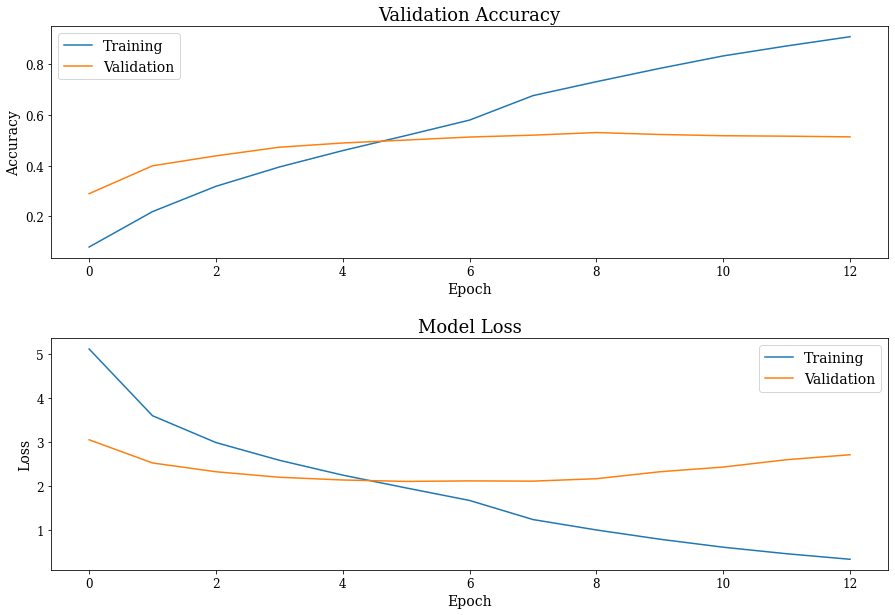

In [7]:
plot_history(history_ft, 'ft.png', metric='categorical_accuracy')

# **VGG16 from scratch**

# 1

In [ ]:
get_and_process_imagenet_data()

load_vgg16_resize_input_to_64x64()

# Load VGG16
modelname = 'scratch_model'
modelname = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers
# for layer in modelname.layers[0:15]:
#     layer.trainable = False
#     print('Layer ' + layer.name + ' frozen.')
    
# Included new fully-connected layers with only 200 activations for 200 classes
# Add the same dense layers as in VGG16
output = modelname.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
# output = BatchNormalization()(output)
# output = Dropout(0.5)(output)
# output = Dense(units=2048, activation='relu')(output)
# output = BatchNormalization()(output)
# output = Dropout(0.6)(output)
# output = Dense(units=1024, activation='relu')(output)
# output = BatchNormalization()(output)
# output = Dropout(0.6)(output)
output = Dense(units=200, activation='softmax')(output)
modelname = Model(modelname.input, output)

modelname.summary()

def lr_scheduler(epoch, lr):
    decay_rate = 0.5
    decay_step = 7
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

lrate = keras.callbacks.LearningRateScheduler(lr_scheduler)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)

modelname.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history_scratch = modelname.fit(train_data, train_labels, epochs=20, batch_size=128, validation_data=(val_data, val_labels), callbacks=[early_stopping])

start_time = time.time()
score = modelname.evaluate(test_data, test_labels)
print(" ")
time_elapsed = time.time() - start_time
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

starting loading data
finished loading data, in 10.979429960250854 seconds
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                  

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
704/704 [==============================] - 120s 153ms/step - loss: 3.3020 - categorical_accuracy: 0.2501 - val_loss: 2.4522 - val_categorical_accuracy: 0.3949
Epoch 2/20
704/704 [==============================] - 104s 148ms/step - loss: 2.0207 - categorical_accuracy: 0.4915 - val_loss: 2.0156 - val_categorical_accuracy: 0.4967
Epoch 3/20
704/704 [==============================] - 108s 153ms/step - loss: 1.5279 - categorical_accuracy: 0.6002 - val_loss: 1.9134 - val_categorical_accuracy: 0.5346
Epoch 4/20
704/704 [==============================] - 110s 156ms/step - loss: 1.1447 - categorical_accuracy: 0.6903 - val_loss: 1.9432 - val_categorical_accuracy: 0.5410
Epoch 5/20
704/704 [==============================] - 111s 158ms/step - loss: 0.8315 - categorical_accuracy: 0.7652 - val_loss: 2.0258 - val_categorical_accuracy: 0.5352
Epoch 6/20
704/704 [==============================] - 109s 156ms/step - loss: 0.5774 - categorical_accuracy: 0.8314 - val_loss: 2.1461 - val_categoric

In [ ]:
plot_history(history_scratch, 'scratch.png', metric='categorical_accuracy')


# 2

In [ ]:
get_and_process_imagenet_data()

load_vgg16_resize_input_to_64x64()

# Load VGG16
modelname = 'scratch2_model'
modelname = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers
# for layer in modelname.layers[0:15]:
#     layer.trainable = False
#     print('Layer ' + layer.name + ' frozen.')
    
# Included new fully-connected layers with only 200 activations for 200 classes
# Add the same dense layers as in VGG16
output = modelname.output
output = Flatten()(output)
output = Dense(units=1024, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
# output = Dense(units=2048, activation='relu')(output)
# output = BatchNormalization()(output)
# output = Dropout(0.6)(output)
# output = Dense(units=1024, activation='relu')(output)
# output = BatchNormalization()(output)
# output = Dropout(0.6)(output)
output = Dense(units=200, activation='softmax')(output)
modelname = Model(modelname.input, output)

modelname.summary()

def lr_scheduler(epoch, lr):
    decay_rate = 0.5
    decay_step = 7
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr

lrate = keras.callbacks.LearningRateScheduler(lr_scheduler)
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)

modelname.compile(optimizer=Adam(learning_rate=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history_scratch2 = modelname.fit(train_data, train_labels, epochs=20, batch_size=128, validation_data=(val_data, val_labels), callbacks=[early_stopping, lrate])

start_time = time.time()
score = modelname.evaluate(test_data, test_labels)
print(" ")
time_elapsed = time.time() - start_time
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

In [ ]:
plot_history(history_scratch2, 'scratch2.png', metric='categorical_accuracy')

# **TinyImageNet**

In [ ]:
get_and_process_imagenet_data()

load_vgg16_resize_input_to_64x64()

# Load VGG16
modelname = 'transferlearning_model'
modelname = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers
for layer in modelname.layers[:]:
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
    
# Included new fully-connected layers with only 200 activations for 200 classes
# Add the same dense layers as in VGG16
output = modelname.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=200, activation='softmax')(output)
modelname = Model(modelname.input, output)

modelname.summary()

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)

modelname.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])
history_tl = modelname.fit(train_data, train_labels, epochs=20, batch_size=128, validation_data=(val_data, val_labels), callbacks=[early_stopping])

start_time = time.time()
score = modelname.evaluate(test_data, test_labels)
print(" ")
time_elapsed = time.time() - start_time
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

starting loading data
finished loading data, in 12.313201904296875 seconds
Layer input_3 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_c

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
704/704 [==============================] - 51s 57ms/step - loss: 2.8193 - categorical_accuracy: 0.3531 - val_loss: 2.3471 - val_categorical_accuracy: 0.4273
Epoch 2/20
704/704 [==============================] - 40s 56ms/step - loss: 2.0129 - categorical_accuracy: 0.5016 - val_loss: 2.2113 - val_categorical_accuracy: 0.4562
Epoch 3/20
704/704 [==============================] - 43s 61ms/step - loss: 1.6635 - categorical_accuracy: 0.5763 - val_loss: 2.1644 - val_categorical_accuracy: 0.4672
Epoch 4/20
704/704 [==============================] - 41s 58ms/step - loss: 1.3605 - categorical_accuracy: 0.6489 - val_loss: 2.1725 - val_categorical_accuracy: 0.4734
Epoch 5/20
704/704 [==============================] - 42s 60ms/step - loss: 1.0700 - categorical_accuracy: 0.7242 - val_loss: 2.2240 - val_categorical_accuracy: 0.4695
Epoch 6/20
704/704 [==============================] - 41s 59ms/step - loss: 0.8067 - categorical_accuracy: 0.7955 - val_loss: 2.3083 - val_categorical_accuracy:

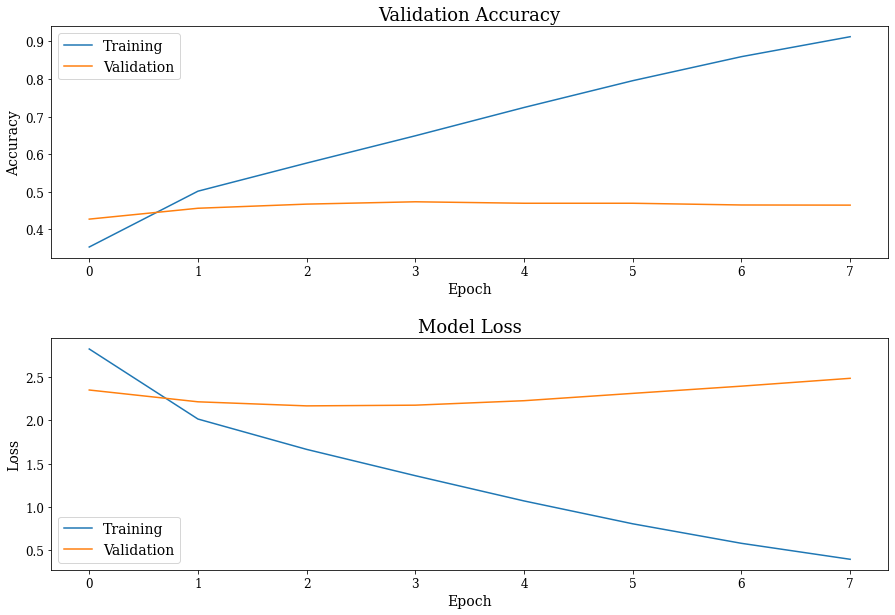

In [ ]:
plot_history(history_tl, 'tl.png', metric='categorical_accuracy')

## Fine-tuning (TinyImageNet)

In [ ]:
get_and_process_imagenet_data();

load_vgg16_resize_input_to_64x64()

# Load VGG16
# TO DO: Change model name!!!
modelname = 'transferlearning_model2'
modelname = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers
for layer in modelname.layers[:]:
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
    
# Included new fully-connected layers with only 200 activations for 200 classes
# Add the same dense layers as in VGG16
output = modelname.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=1024, activation='relu')(output)
output = Dense(units=200, activation='softmax')(output)
modelname = Model(modelname.input, output)

modelname.summary()

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)

modelname.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# TO DO: Change history name!!!
history_tl2 = modelname.fit(train_data, train_labels, epochs=20, batch_size=128, validation_data=(val_data, val_labels), callbacks=[early_stopping])

start_time = time.time()
score = modelname.evaluate(test_data, test_labels)
print(" ")
time_elapsed = time.time() - start_time
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

starting loading data
finished loading data, in 11.422914505004883 seconds
Layer input_6 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_c

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
704/704 [==============================] - 49s 69ms/step - loss: 2.9692 - categorical_accuracy: 0.3172 - val_loss: 2.4146 - val_categorical_accuracy: 0.4073
Epoch 2/20
704/704 [==============================] - 47s 66ms/step - loss: 2.1339 - categorical_accuracy: 0.4695 - val_loss: 2.2656 - val_categorical_accuracy: 0.4470
Epoch 3/20
704/704 [==============================] - 47s 66ms/step - loss: 1.7465 - categorical_accuracy: 0.5527 - val_loss: 2.2519 - val_categorical_accuracy: 0.4518
Epoch 4/20
704/704 [==============================] - 47s 66ms/step - loss: 1.3704 - categorical_accuracy: 0.6374 - val_loss: 2.2351 - val_categorical_accuracy: 0.4663
Epoch 5/20
704/704 [==============================] - 47s 66ms/step - loss: 0.9769 - categorical_accuracy: 0.7366 - val_loss: 2.4163 - val_categorical_accuracy: 0.4551
Epoch 6/20
704/704 [==============================] - 47s 66ms/step - loss: 0.6079 - categorical_accuracy: 0.8346 - val_loss: 2.6153 - val_categorical_accuracy:

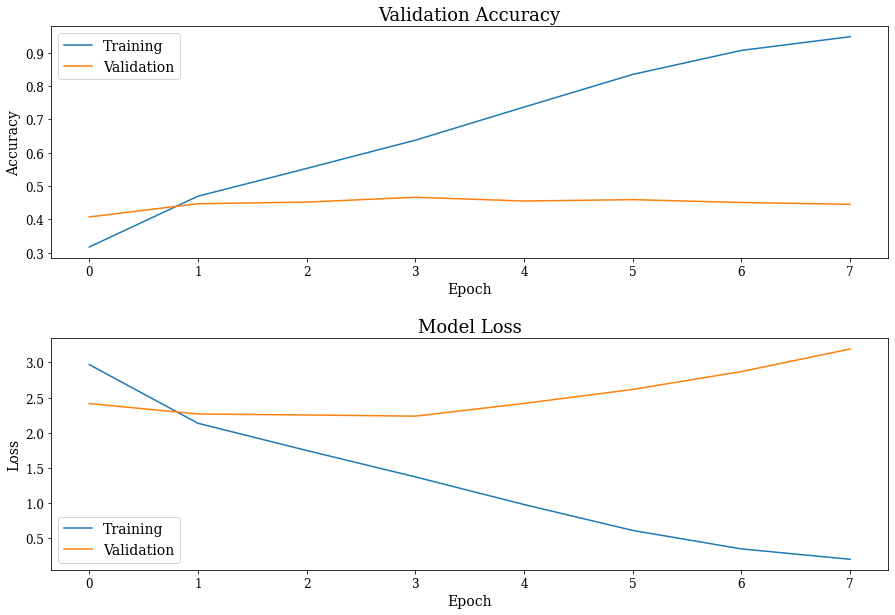

In [ ]:
plot_history(history_tl2, 'tl2.png', metric='categorical_accuracy')

In [ ]:
get_and_process_imagenet_data();

load_vgg16_resize_input_to_64x64()

# Load VGG16
# TO DO: Change model name!!!
modelname = 'transferlearning_model3'
modelname = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers
for layer in modelname.layers[:]:
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
    
# Included new fully-connected layers with only 200 activations for 200 classes
# Add the same dense layers as in VGG16
output = modelname.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=4096, activation='relu')(output)
output = Dense(units=2048, activation='relu')(output)
output = Dense(units=1024, activation='relu')(output)
output = Dense(units=200, activation='softmax')(output)
modelname = Model(modelname.input, output)

modelname.summary()

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)

modelname.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# TO DO: Change history name!!!
history_tl3 = modelname.fit(train_data, train_labels, epochs=20, batch_size=128, validation_data=(val_data, val_labels), callbacks=[early_stopping])

start_time = time.time()
score = modelname.evaluate(test_data, test_labels)
print(" ")
time_elapsed = time.time() - start_time
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

starting loading data
finished loading data, in 11.128244638442993 seconds
Layer input_18 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1

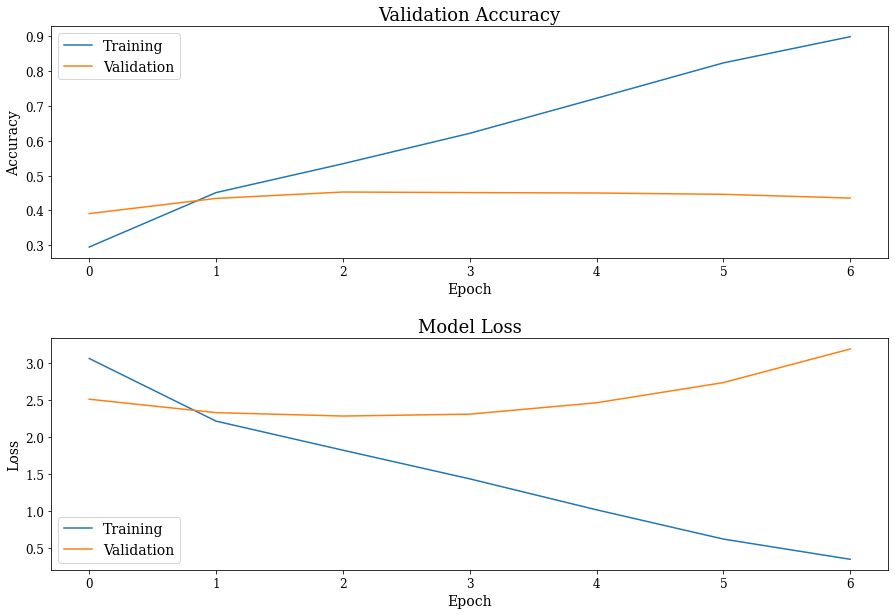

In [ ]:
plot_history(history_tl3, 'tl3.png', metric='categorical_accuracy')

In [ ]:
get_and_process_imagenet_data();

load_vgg16_resize_input_to_64x64()

# Load VGG16
# TO DO: Change model name!!!
modelname = 'transferlearning_model4'
modelname = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers
for layer in modelname.layers[:]:
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
    
# Included new fully-connected layers with only 200 activations for 200 classes
# Add the same dense layers as in VGG16
output = modelname.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.3)(output)
output = Dense(units=4096, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.3)(output)
output = Dense(units=1024, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.3)(output)
output = Dense(units=200, activation='softmax')(output)
modelname = Model(modelname.input, output)

modelname.summary()

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)

modelname.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# TO DO: Change history name!!!
history_tl4 = modelname.fit(train_data, train_labels, epochs=20, batch_size=128, validation_data=(val_data, val_labels), callbacks=[early_stopping])

start_time = time.time()
score = modelname.evaluate(test_data, test_labels)
print(" ")
time_elapsed = time.time() - start_time
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

starting loading data
finished loading data, in 11.102234363555908 seconds
Layer input_15 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.
Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
704/704 [==============================] - 46s 64ms/step - loss: 3.3990 - categorical_accuracy: 0.2730 - val_loss: 2.4186 - val_categorical_accuracy: 0.4225
Epoch 2/20
704/704 [==============================] - 42s 60ms/step - loss: 2.4235 - categorical_accuracy: 0.4240 - val_loss: 2.2593 - val_categorical_accuracy: 0.4546
Epoch 3/20
704/704 [==============================] - 43s 61ms/step - loss: 2.0796 - categorical_accuracy: 0.4875 - val_loss: 2.2153 - val_categorical_accuracy: 0.4632
Epoch 4/20
704/704 [==============================] - 43s 61ms/step - loss: 1.8111 - categorical_accuracy: 0.5407 - val_loss: 2.1882 - val_categorical_accuracy: 0.4751
Epoch 5/20
704/704 [==============================] - 43s 61ms/step - loss: 1.5696 - categorical_accuracy: 0.5931 - val_loss: 2.2037 - val_categorical_accuracy: 0.4754
Epoch 6/20
704/704 [==============================] - 43s 61ms/step - loss: 1.3565 - categorical_accuracy: 0.6413 - val_loss: 2.2102 - val_categorical_accuracy:

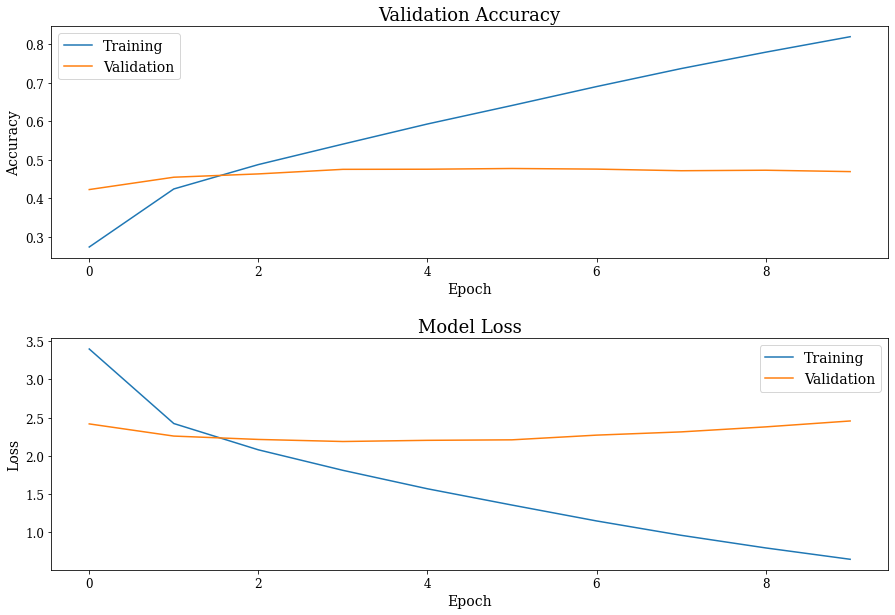

In [ ]:
plot_history(history_tl4, 'tl4.png', metric='categorical_accuracy')

In [ ]:
get_and_process_imagenet_data();

load_vgg16_resize_input_to_64x64()

# Load VGG16
# TO DO: Change model name!!!
modelname = 'transferlearning_model5'
modelname = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))

# Freeze the layers
for layer in modelname.layers[:]:
    layer.trainable = False
    print('Layer ' + layer.name + ' frozen.')
    
# Included new fully-connected layers with only 200 activations for 200 classes
# Add the same dense layers as in VGG16
output = modelname.output
output = Flatten()(output)
output = Dense(units=4096, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(units=4096, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(units=1024, activation='relu')(output)
output = BatchNormalization()(output)
output = Dropout(0.5)(output)
output = Dense(units=200, activation='softmax')(output)
modelname = Model(modelname.input, output)

modelname.summary()

early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=4, restore_best_weights=True)

modelname.compile(optimizer=Adam(lr=1e-4),loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# TO DO: Change history name!!!
history_tl5 = modelname.fit(train_data, train_labels, epochs=20, batch_size=128, validation_data=(val_data, val_labels), callbacks=[early_stopping])

start_time = time.time()
score = modelname.evaluate(test_data, test_labels)
print(" ")
time_elapsed = time.time() - start_time
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('Average inference time per image: {:.4f} (ms)'.format(1000*time_elapsed/len(test_data)))

starting loading data
finished loading data, in 11.206910610198975 seconds
Layer input_21 frozen.
Layer block1_conv1 frozen.
Layer block1_conv2 frozen.
Layer block1_pool frozen.
Layer block2_conv1 frozen.
Layer block2_conv2 frozen.
Layer block2_pool frozen.
Layer block3_conv1 frozen.
Layer block3_conv2 frozen.
Layer block3_conv3 frozen.
Layer block3_pool frozen.
Layer block4_conv1 frozen.
Layer block4_conv2 frozen.
Layer block4_conv3 frozen.
Layer block4_pool frozen.
Layer block5_conv1 frozen.
Layer block5_conv2 frozen.
Layer block5_conv3 frozen.
Layer block5_pool frozen.
Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_21 (InputLayer)       [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/20
704/704 [==============================] - 47s 65ms/step - loss: 4.2487 - categorical_accuracy: 0.1686 - val_loss: 2.5879 - val_categorical_accuracy: 0.3867
Epoch 2/20
704/704 [==============================] - 42s 60ms/step - loss: 3.1051 - categorical_accuracy: 0.3079 - val_loss: 2.3697 - val_categorical_accuracy: 0.4335
Epoch 3/20
704/704 [==============================] - 43s 61ms/step - loss: 2.7768 - categorical_accuracy: 0.3598 - val_loss: 2.2780 - val_categorical_accuracy: 0.4461
Epoch 4/20
704/704 [==============================] - 43s 60ms/step - loss: 2.5611 - categorical_accuracy: 0.3973 - val_loss: 2.2078 - val_categorical_accuracy: 0.4640
Epoch 5/20
704/704 [==============================] - 43s 61ms/step - loss: 2.4043 - categorical_accuracy: 0.4256 - val_loss: 2.1755 - val_categorical_accuracy: 0.4704
Epoch 6/20
704/704 [==============================] - 43s 61ms/step - loss: 2.2730 - categorical_accuracy: 0.4470 - val_loss: 2.1528 - val_categorical_accuracy:

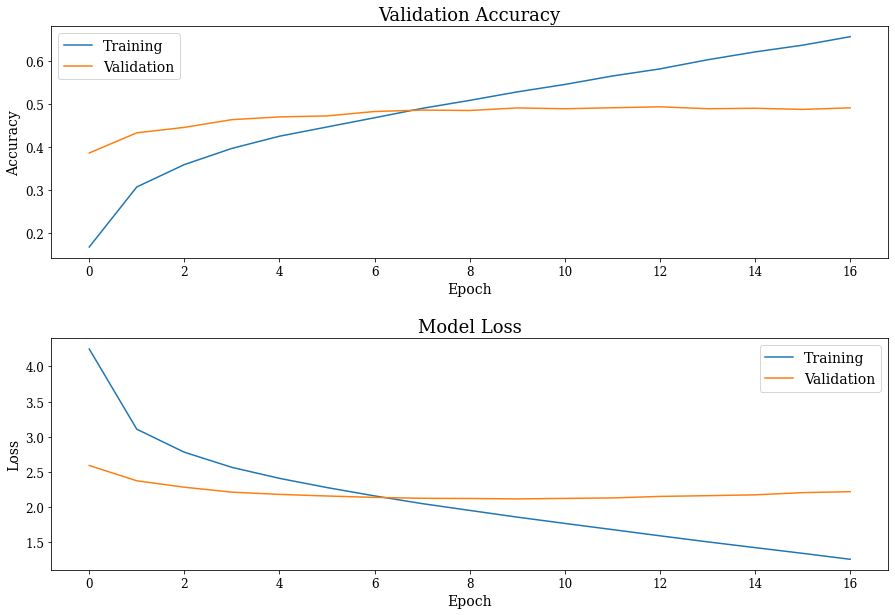

In [ ]:
plot_history(history_tl5, 'tl5.png', metric='categorical_accuracy')

# **Plot training and validation accuracy curves for VGG16 trained from scratch, Transfer Learning, Fine-tuning VGG16**

In [ ]:
def addlabels(x,y):
  for i in range(len(x)):
    plt.text(i, y, y, ha='center', fontsize=13)

fig = plt.figure(figsize=(15,4.5))

plt.plot(history_tl.history['categorical_accuracy'], linestyle='dotted', color='purple', label='lr = 0.0003')
plt.plot(history_tl.history['val_categorical_accuracy'], color='purple', label='lr = 0.0003')

plt.title('Training and Validation Accuracy', fontsize = 18)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylabel('Accuracy', fontsize = 14)
plt.xlabel('Epoch', fontsize = 14)

# plt.text(16, 1.18, 'lr = 0.003', fontsize=14)
# plt.text(16, 1.5, 'lr = 0.001', fontsize=14)
# plt.text(16, 1.9, 'lr = 0.0003', fontsize=14)

plt.legend(['Training', 'Validation'], fontsize=14, loc='upper right')

directory = '/content/drive/MyDrive/dl-cw-04/diagrams/'

if not os.path.exists(directory):
  os.makedirs(directory)

fig.savefig(os.path.join(directory, 'vgg16.png'))